In [1]:
# script to model avergage trip distances for commute trips in all cities
# last update Peter Berrill Aug 1 2023

# load in required packages
import numpy as np
import pandas as pd
import shap
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, GroupKFold, StratifiedGroupKFold, RepeatedKFold, StratifiedKFold, GridSearchCV, KFold
from sklearn import metrics, linear_model
from xgboost import XGBClassifier, XGBRegressor
import os
import sys
import matplotlib.pyplot as plt
import pickle
import statsmodels.formula.api as smf
from datetime import datetime

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien','France_other','Germany_other']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria','France','Germany']


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
city='Berlin'
country=countries[cities_all.index(city)]
print(city, country)

city0='Berlin'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
# add to make consistent with definition of apprenticeship within Education in other countries
df0.loc[(df0['Training'].isin(['Apprenticeship/Business','Craftsman/Technical'])) & (df0['Education']!='University'),'Education']='Apprenticeship'
df0=df0.loc[:,['HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode', 
            'Trip_Time', 'Season','Trip_Purpose_Agg','HHSize',
            'Sex', 'Occupation', 'Education','Age',
            #'PopDensity_res','BuildDensity_res',
            'UrbPopDensity_res', 'UrbBuildDensity_res','DistSubcenter_res', 'DistCenter_res',
            'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
            'LU_Comm_res' ,'Trip_Distance']]
df0['City']=city0
df0['Country']='Germany'
df_all=df0.copy()

cities0=['Dresden', 'Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
for city1 in cities0:
        print(city1)
        df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
        df1.loc[(df1['Training'].isin(['Apprenticeship/Business','Craftsman/Technical'])) & (df0['Education']!='University'),'Education']='Apprenticeship'
        df1=df1.loc[:,['HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode', 
                    'Trip_Time', 'Season','Trip_Purpose_Agg','HHSize',
                    'Sex', 'Occupation', 'Education','Age',
                    #'PopDensity_res','BuildDensity_res',
                    'UrbPopDensity_res', 'UrbBuildDensity_res','DistSubcenter_res', 'DistCenter_res',
                    'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
                    'LU_Comm_res','Trip_Distance']]
        df1['City']=city1
        df1['Country']='Germany'
        if len(df1.columns==df_all.columns):
                df_all=pd.concat([df_all,df1])
                print(city1, 'added.')
                #print(len(df_all), 'rows in the combined dataframe')
df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)
df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(int).astype(str)
df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(str)
df_all.drop(columns='City',inplace=True)
df_DE=df_all.copy()

Berlin Germany


Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


Dresden
Dresden added.
Leipzig
Leipzig added.
Magdeburg
Magdeburg added.
Potsdam
Potsdam added.
Frankfurt am Main
Frankfurt am Main added.
Düsseldorf
Düsseldorf added.
Kassel


Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.


Kassel added.


In [3]:
city0='Clermont'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
df0=df0.loc[:,['HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode', 
            'Trip_Time', 'Season','Trip_Purpose_Agg','HHSize',
            'Sex', 'Occupation', 'Education','Age',
            #'PopDensity_res','BuildDensity_res',
            'UrbPopDensity_res', 'UrbBuildDensity_res','DistSubcenter_res', 'DistCenter_res',
            'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
            'LU_Comm_res', 'Trip_Distance']]
df0['City']=city0
df0['Country']='France'
df_all=df0.copy()

cities0=['Toulouse','Montpellier','Lyon','Nantes','Nimes','Lille','Dijon','Paris']
for city1 in cities0:
        print(city1)
        df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
        df1=df1.loc[:,['HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode', 
                    'Trip_Time', 'Season','Trip_Purpose_Agg','HHSize',
                    'Sex', 'Occupation', 'Education','Age',
                    #'PopDensity_res','BuildDensity_res',
                    'UrbPopDensity_res', 'UrbBuildDensity_res','DistSubcenter_res', 'DistCenter_res',
                    'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
                    'LU_Comm_res', 'Trip_Distance']]
        df1['City']=city1
        df1['Country']='France'
        if len(df1.columns==df_all.columns):
                df_all=pd.concat([df_all,df1])
                print(city1, 'added.')
                #print(len(df_all), 'rows in the combined dataframe')
df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(str)
df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(str)
df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(str)
df_all.drop(columns='City',inplace=True)
df_FR=df_all.copy()

Toulouse
Toulouse added.
Montpellier
Montpellier added.
Lyon
Lyon added.
Nantes
Nantes added.
Nimes
Nimes added.
Lille
Lille added.
Dijon
Dijon added.
Paris
Paris added.


In [4]:
df=pd.read_csv('../outputs/Combined/' + 'Madrid' + '_UF.csv',dtype={'Ori_geocode': str, 'Des_geocode': str,'Res_geocode': str })
df_UF=df.loc[:,['HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode', 
                'Trip_Time', 'Season','Trip_Purpose_Agg','HHSize',
                'Sex', 'Occupation', 'Education','Age',
                #'PopDensity_res','BuildDensity_res',
                'UrbPopDensity_res', 'UrbBuildDensity_res','DistSubcenter_res', 'DistCenter_res',
                'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
                'LU_Comm_res', 'Trip_Distance']]
df_UF['City']='Madrid'
df_UF['Country']='Spain'
df_UF['HHNR']=df_UF['City']+'_'+df_UF['HHNR'].astype(str)
df_UF['HH_PNR']=df_UF['City']+'_'+df_UF['HH_PNR'].astype(str)
df_UF['HH_P_WNR']=df_UF['City']+'_'+df_UF['HH_P_WNR'].astype(str)
df_UF.drop(columns='City',inplace=True)
df_Madrid=df_UF.copy()

In [5]:
df=pd.read_csv('../outputs/Combined/' + 'Wien' + '_UF.csv',dtype={'Ori_geocode': str, 'Des_geocode': str,'Res_geocode': str })
df_UF=df.loc[:,['HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode', 
                'Trip_Time', 'Season','Trip_Purpose_Agg','HHSize',
                'Sex', 'Occupation', 'Education','Age',
                #'PopDensity_res','BuildDensity_res',
                'UrbPopDensity_res', 'UrbBuildDensity_res','DistSubcenter_res', 'DistCenter_res',
                'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
                'LU_Comm_res', 'Trip_Distance']]
df_UF['City']='Wien'
df_UF['Country']='Austria'
df_UF['HHNR']=df_UF['City']+'_'+df_UF['HHNR'].astype(str)
df_UF['HH_PNR']=df_UF['City']+'_'+df_UF['HH_PNR'].astype(str)
df_UF['HH_P_WNR']=df_UF['City']+'_'+df_UF['HH_P_WNR'].astype(str)
df_UF.drop(columns='City',inplace=True)
df_Wien=df_UF.copy()

In [6]:
df_UF=pd.concat([df_DE,df_FR,df_Madrid,df_Wien],ignore_index=True)
df_UF['Trip_Purpose_Agg'].value_counts()

Home↔Leisure      156611
Other             132906
Home↔Work         130623
Home↔Shopping     108008
Home↔School        83984
Home↔Companion     62002
Name: Trip_Purpose_Agg, dtype: int64

In [8]:
df_UF.columns

Index(['HH_P_WNR', 'HH_PNR', 'HHNR', 'Ori_geocode', 'Des_geocode',
       'Res_geocode', 'Trip_Time', 'Season', 'Trip_Purpose_Agg', 'HHSize',
       'Sex', 'Occupation', 'Education', 'Age', 'UrbPopDensity_res',
       'UrbBuildDensity_res', 'DistSubcenter_res', 'DistCenter_res',
       'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',
       'LU_Comm_res', 'Trip_Distance', 'Country'],
      dtype='object')

In [11]:
df_UF['Country'].value_counts()

France     293160
Germany    192614
Spain      168588
Austria     19772
Name: Country, dtype: int64

In [12]:
print(len(df_UF['HH_P_WNR'].unique()))

674134


In [13]:
print(len(df_UF['HHNR'].unique()))

106506


In [10]:
print(len(df_UF['HH_PNR'].unique()))

186814

In [7]:
df_UF=pd.concat([df_DE,df_FR,df_Madrid,df_Wien],ignore_index=True)
df_UF=df_UF.loc[df_UF['Trip_Purpose_Agg']=='Home↔Work',]
df_UF.drop(columns='Trip_Purpose_Agg',inplace=True)

Occ_dict={'Employed_FullTime':'Employed','Employed_PartTime':'Employed','Employed':'Employed','Trainee':'Employed',
          'Student_School':'Student_School','Student_3rdLevel':'Student_3rdLevel','Pre-School':'Pre-School','Retired':'Retired',
          'Unemployed':'Unemployed/Other','Other':'Unemployed/Other','Home_Partner':'Unemployed/Other'}
Edu_dict={'University':'University','Secondary':'Secondary','Secondary+BAC':'Secondary','Secondary+Matura':'Secondary',
          'Apprenticeship':'Apprenticeship',
          'Elementary':'Primary/None','Pre-School':'Primary/None','No diploma yet':'Primary/None','Unknown':'Primary/None','Other':'Primary/None'}

df_UF['Occupation']=df_UF['Occupation'].map(Occ_dict)
df_UF['Education']=df_UF['Education'].map(Edu_dict)

df_UF=pd.concat([df_UF.drop(columns='Trip_Distance'),df_UF['Trip_Distance']],axis=1)
df_UF

,HH_P_WNR,HH_PNR,HHNR,Ori_geocode,Des_geocode,Res_geocode,Trip_Time,Season,HHSize,Sex,...,UrbPopDensity_res,UrbBuildDensity_res,DistSubcenter_res,DistCenter_res,IntersecDensity_res,street_length_res,LU_UrbFab_res,LU_Comm_res,Country,Trip_Distance
0,Berlin_102956_1_1,Berlin_1029561,Berlin_102956,10115,10115,10115,Daytime Off-Peak,Spring,1.0,2,...,11691.822806,9.010181e+06,2.761334,1.972959,39.380867,127.710059,0.395459,0.366144,Germany,729.0
1,Berlin_102956_1_2,Berlin_1029561,Berlin_102956,10115,10115,10115,Daytime Off-Peak,Spring,1.0,2,...,11691.822806,9.010181e+06,2.761334,1.972959,39.380867,127.710059,0.395459,0.366144,Germany,729.0
2,Berlin_102964_1_1,Berlin_1029641,Berlin_102964,10115,10245,10115,AM_Rush,Winter,4.0,1,...,11691.822806,9.010181e+06,2.761334,1.972959,39.380867,127.710059,0.395459,0.366144,Germany,6259.0
3,Berlin_102964_1_2,Berlin_1029641,Berlin_102964,10245,10115,10115,PM Rush,Winter,4.0,1,...,11691.822806,9.010181e+06,2.761334,1.972959,39.380867,127.710059,0.395459,0.366144,Germany,6259.0
4,Berlin_102964_2_1,Berlin_1029642,Berlin_102964,10115,10178,10115,Daytime Off-Peak,Winter,4.0,2,...,11691.822806,9.010181e+06,2.761334,1.972959,39.380867,127.710059,0.395459,0.366144,Germany,1474.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674104,Wien_6972_2_1,Wien_6972_2,Wien_6972,31701,31719,31701,AM_Rush,Autumn,2.0,2,...,1067.228835,4.250415e+03,8.251874,13.787251,6.937562,135.293102,0.038474,0.023820,Austria,20000.0
674107,Wien_6972_2_4,Wien_6972_2,Wien_6972,91101,31701,31701,Daytime Off-Peak,Autumn,2.0,2,...,1067.228835,4.250415e+03,8.251874,13.787251,6.937562,135.293102,0.038474,0.023820,Austria,25000.0
674116,Wien_9066_3_1,Wien_9066_3,Wien_9066,31701,90301,31701,AM_Rush,Autumn,4.0,2,...,1067.228835,4.250415e+03,8.251874,13.787251,6.937562,135.293102,0.038474,0.023820,Austria,21000.0
674117,Wien_9066_3_2,Wien_9066_3,Wien_9066,90301,31701,31701,Lunch,Autumn,4.0,2,...,1067.228835,4.250415e+03,8.251874,13.787251,6.937562,135.293102,0.038474,0.023820,Austria,21000.0


In [8]:
df=df_UF.dropna()
df['Sex']=df['Sex']-1 # change from [1,2] to [0,1], for plotting purposes
df=df.loc[df['UrbBuildDensity_res']<1e8,]   # remove high building density outliers (For Leipzig)
# identify the feature columns
N_non_feature=6 # how many non-features are at the start of the df
cols=df.columns
newcols=(df.columns[:N_non_feature].tolist()) + ('FeatureD' +'_'+ cols[N_non_feature:-1]).tolist() + (df.columns[-1:].tolist())
# change column names
df.set_axis(newcols,axis=1,inplace=True)
df = df.reset_index(drop=True)
df0=df.copy()

# convert  all categorical variables to dummies
df_Cat=df.select_dtypes('object')[[col for col in df.select_dtypes('object').columns if "FeatureD" in col]]
for col in df_Cat:
    dum=pd.get_dummies(df[[col]])
    df = pd.concat([df, dum], axis = 1)
    # remove the original categorical columns
df.drop(df_Cat.columns.tolist(),axis=1,inplace=True)
# HPO with full dataset, grouping by individual person
target = 'Trip_Distance'
N=len(df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
city='All'

0  columns with value below zero
HPs already identified
id 44536427


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


id 51382313


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


id 58285398


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


id 05652311


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


id 13629612


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


id 21565165


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


id 29674514


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


id 39809244


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


id 49939229


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


GBDT Model r2: All
0.15908399586236455
LR Model r2: All
0.12455827454850199


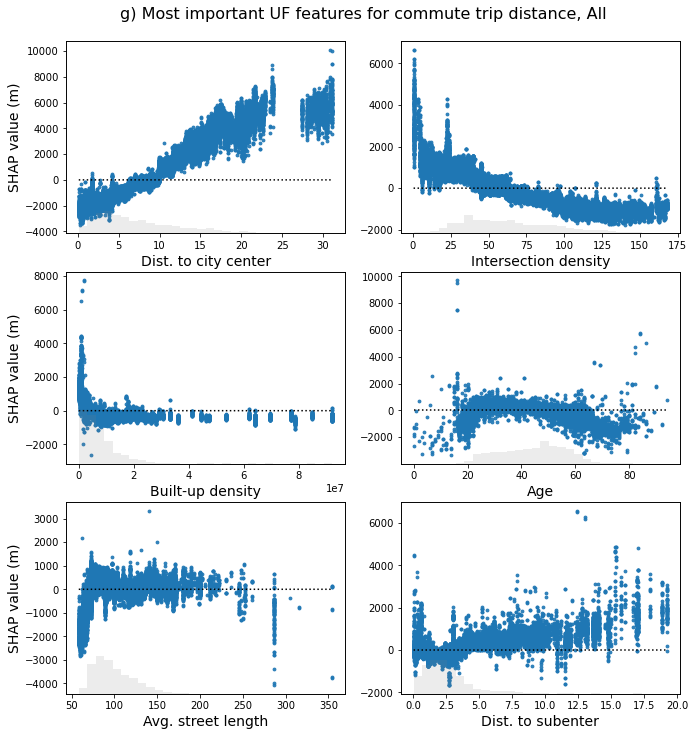

In [10]:
# Define the parameter space to be considered
PS = {"learning_rate": [0.1 ,0.15,0.2], 
                "n_estimators": [100, 200],
                "max_depth":[3, 4]}

X=df[[col for col in df.columns if "FeatureD" in col]]
y = df[target]

tf=(X < 0).all(0)
print(len(tf[tf]),' columns with value below zero')
if len(tf[tf])>0:
    print(tf[tf].index.values)
    raise Exception("Some columns have values below zero")

gr=df['HH_PNR']
groups=gr
gkf = list(GroupKFold(n_splits=9).split(X,y,groups)) # i found somewhere online that i had to define the cv splitter as a list, can't find the source at the moment.

fp='../outputs/ML_Results/'+city+'_HPO_dist_commute_summary.csv'
if os.path.isfile(fp):
    print('HPs already identified')
    HPO_summary=pd.read_csv(fp)
    n_parameter_all = HPO_summary['N_est'][0]
    lr_parameter_all = HPO_summary['LR'][0]
    md_parameter_all = HPO_summary['MD'][0]
else:
    # define grid search cross validator
    tuning_all = GridSearchCV(estimator=XGBRegressor(verbosity=0,use_label_encoder=False), param_grid=PS, cv=gkf, scoring="r2",return_train_score=True)
    tuning_all.fit(X,y)

    print('best hyper-parameters identified by HPO')
    print(tuning_all.best_params_)
    print('model score with best hyper-paramteres')
    print(tuning_all.best_score_)
    cv_res_all=tuning_all.cv_results_

    n_parameter_all = tuning_all.best_params_['n_estimators']
    lr_parameter_all = tuning_all.best_params_['learning_rate']
    md_parameter_all = tuning_all.best_params_['max_depth']

    # save results of HPO
    r8=['gkf_gridSearch','full','9splits_hhperGroups',tuning_all.best_params_['learning_rate'],tuning_all.best_params_['max_depth'],tuning_all.best_params_['n_estimators'],round(tuning_all.best_score_,3),round(cv_res_all['std_test_score'][tuning_all.best_index_],3),N] #
    # also include other results lists here if HPO is done for more than one cv type or sample
    HPO_summary=pd.DataFrame([r8],columns=['CV_Type','Sample','CV_params','LR','MD','N_est','F1_best','SD_best','N_obs']) # the last element in this case is the sd of f1 scores in the fold which produced best results

# now redo the CV and calculate the SHAP values with the best HPs
cv = GroupKFold(n_splits=9)

y_predict = pd.DataFrame()
y_predict2 = pd.DataFrame()
y_test = pd.DataFrame()
y_test2 = pd.DataFrame()

shap_values = pd.DataFrame()

r2ml=[]
r2lr=[]
summ_table_list=[]

model = XGBRegressor(
    max_depth=md_parameter_all, 
    n_estimators=n_parameter_all, 
    learning_rate=lr_parameter_all)

writer = pd.ExcelWriter('../outputs/ML_Results/dist_commute/'  + city + '.xlsx', engine='openpyxl')
form_str="Trip_Distance ~  FeatureD_HHSize + FeatureD_Sex + FeatureD_Education + FeatureD_Age + FeatureD_Season +  FeatureD_DistSubcenter_res + FeatureD_DistCenter_res + FeatureD_UrbPopDensity_res + FeatureD_UrbBuildDensity_res  + FeatureD_IntersecDensity_res + FeatureD_street_length_res + FeatureD_LU_Comm_res +  FeatureD_LU_UrbFab_res + FeatureD_Country" # + FeatureD_bike_lane_share_res 

for train_idx, test_idx in cv.split(X,groups=gr): # select here 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    df_train, df_test = df0.iloc[train_idx], df0.iloc[test_idx]
    y_test_fold2=df_test['Trip_Distance']
    id=datetime.now().strftime("%S%f")
    print('id',id)

    # train & predict
    model.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_test, y_test_fold)])
    y_predict_fold = pd.Series(model.predict(X_test), index=X_test.index)
    r2ml.extend([metrics.r2_score(y_test_fold.array, y_predict_fold.array)])
    # explain
    explainer = shap.TreeExplainer(model)
    
    shap_values_fold = explainer.shap_values(X_test,check_additivity=False)
    
    shap_values_fold = pd.DataFrame(shap_values_fold, index=X_test.index, columns=X.columns) 

    y_predict = pd.concat([y_predict, y_predict_fold], axis=0)
    y_test = pd.concat([y_test, y_test_fold], axis=0)

    shap_values = pd.concat([shap_values, shap_values_fold], axis=0)
    
    lin_reg = smf.ols(form_str, data=df_train).fit()
    yhat=np.asarray(lin_reg.predict(df_test.drop(columns='Trip_Distance')))
    y_predict_fold2 = pd.Series(yhat, index=df_test.index)
    y_predict2 = pd.concat([y_predict2, y_predict_fold2], axis=0)
    y_test2 = pd.concat([y_test2, y_test_fold2], axis=0)
    
    r2lr.extend([metrics.r2_score(y_test_fold.array, y_predict_fold2.array)])

    coeff=lin_reg.params.reset_index()
    coeff.rename(columns={'index':'param',0:'coefficient'},inplace=True)

    pval=lin_reg.pvalues.reset_index()
    pval.rename(columns={'index':'param',0:'p'},inplace=True)

    summ_table=pd.concat([coeff,pval['p']],axis=1)
    summ_table['param']=summ_table['param'].str.replace('FeatureD_','')

    st_list_fold=[summ_table.drop(columns='param').to_numpy()]
    summ_table_list.append(st_list_fold)

    summ_table.to_excel(writer, sheet_name='summ' + id,index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()
writer.close()

mdarray=np.array(summ_table_list).squeeze()
means=np.nanmean(mdarray,axis=0)
means_df=pd.DataFrame(data=np.hstack((np.reshape(summ_table['param'].to_numpy(),(len(summ_table),1)),means)),columns=summ_table.columns.values)
means_df.to_csv('../outputs/ML_Results/dist_commute/'  + city + '_mean.csv',index=False)

y_test = y_test.squeeze(axis=1)
y_test2 = y_test2.squeeze(axis=1)
y_predict = y_predict.squeeze(axis=1)
y_predict2 = y_predict2.squeeze(axis=1)
r2_model=metrics.r2_score(y_test, y_predict)
r2_model_reg=metrics.r2_score(y_test2, y_predict2)
print('GBDT Model r2: ' + city)
print(r2_model)
print('LR Model r2: ' + city)
print(r2_model_reg)
HPO_summary['R2_full_ML']=r2_model
HPO_summary['R2_full_LR']=r2_model_reg
HPO_summary['City']=city
HPO_summary.to_csv('../outputs/ML_Results/' + city + '_HPO_dist_commute_summary.csv',index=False)

X_disp=[re.sub('FeatureD_','', x) for x in X.columns]

#X_disp=[re.sub('featureD_','', x) for x in X.columns]

shap_values=shap_values.sort_index()
shap_values.reset_index(inplace=True)
shap_values=shap_values.groupby('index').mean().reset_index()
shap_values.drop(columns=['index'],inplace=True)

shap.summary_plot(shap_values.sort_index().to_numpy(), X.sort_index(),feature_names=X_disp,max_display=14,show=False)
plt.title('Feature Influence for Trip Distance, ' + city + ', R2: ' + round(r2_model,3).astype(str))
plt.xlabel("SHAP value (impact on distance, in m)")
plt.savefig('../outputs/ML_Results/result_figures/dist_commute/' + city + '_FI_distance.png',facecolor='w',dpi=65,bbox_inches='tight')
plt.close()
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_disp, shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

#n=importance_df[:10].index
n=importance_df.loc[importance_df['column_name'].isin(['DistCenter_res','DistSubcenter_res','UrbBuildDensity_res','IntersecDensity_res','UrbPopDensity_res','street_length_res','LU_Comm_res','LU_UrbFab_res','Age'])].index

X.sort_index(inplace=True)
data=X.sort_index().iloc[:,n]
data.columns=data.columns.str.replace("FeatureD_", "")
values=shap_values.sort_index().iloc[:,n]

col_dict= {'DistCenter_res':'Dist. to city center','DistSubcenter_res':'Dist. to subenter', 'UrbPopDensity_res':'Population density','UrbBuildDensity_res':'Built-up density',
    'IntersecDensity_res':'Intersection density','LU_Comm_res':'Commercial area','LU_UrbFab_res':'Urban Fabric area','street_length_res':'Avg. street length','bike_lane_share_res':'Cycle lanes',
    'Trip_Time_Evening':'Evening trip','Trip_Time_AM_Rush':'Morning trip','Trip_Time_Nighttime Off-Peak':'Nighttime trip','Trip_Time_Lunch':'Lunchtime trip',
    'Season_Winter':'Winter season',
    'Age':'Age','Sex':'Sex','HHSize':'Household size',
    'Education_University':'University education', 'Occupation_Employed_FullTime':'Employed'}
data.rename(columns=col_dict,inplace=True)


if city == 'Berlin': let='a'
if city == 'Paris': let='b'
if city == 'Madrid': let='c'
if city == 'Wien': let='d'
if city == 'Germany_other': let='e'
if city == 'France_other': let='f'
if city == 'All': let='g'

xl=[]
yl=[]
y0=[]

for i in range(len(n)):
        dftemp=pd.DataFrame({'d':data.iloc[:,i],'v':values.iloc[:,i]})
        dftemp=dftemp.groupby('d')['v'].mean().reset_index()
        dftemp['v0']=0
        xl.append(dftemp['d'].values)
        yl.append(dftemp['v'].values)
        y0.append(dftemp['v0'].values)

fig = plt.figure(figsize=(11,12))
for i in range(0,6):
        ax1 = fig.add_subplot(321+i)
        xs=data.iloc[:,i]
        ys=values.iloc[:,i]
        x=xl[i]
        y1=y0[i]
        y2=yl[i]
        xlab=data.columns[i]

        #ax1.scatter(xs+np.random.normal(0, 0.05, len(data)),ys,alpha=0.9,s=8)
        ax1.scatter(xs,ys,alpha=0.9,s=8)
        plt.plot(x,y1,'k:',label='zero')
        if (xlab== 'Built-up density') & (city == 'Germany_other'):
                plt.xlim([0, 2e7])
        if i%2==0:
                ax1.set_ylabel('SHAP value (m)',size=14)
        else:
                ax1.set_ylabel('')
        ax1.set_xlabel(xlab,size=14)

        ax2 = ax1.twinx() 
        if len(xs.unique())==2:
                ax2.hist(xs,bins=[-0.5,0.5,1.5], align='mid',color='gray',alpha=0.25)
                ax2.set_xticks([-.5,0,0.5,1,1.5])
        else:
                ax2.hist(xs,bins=30,color='gray',alpha=0.15)
                ax2.set_ylim(0,len(data))
        ax2.set_yticks([])
plt.suptitle(let + ') ' +  "Most important UF features for commute trip distance, " + city.replace('_',', '),y=0.92,size=16)
plt.savefig('../outputs/ML_Results/result_figures/dist_commute/' + city + '_mainUF.png',facecolor='w',dpi=65,bbox_inches='tight')